In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#importing libraries
from sklearn.datasets import load_boston
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [73]:
df=pd.read_csv('D:\\UserData\\SCM\\OneDrive_2020-08-13\\CSV\\FactoryDemand_master1.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df = df['2015-12-01':]
df.shape

(55, 162)

# Removing BLS Variables

Employment and related variables from Bureau of Labor Statistics
Employment creation for welders, location quotient and wage information is available on BLS. The data is available for Sacramento, California and US
The Unavilability of data is a major hinderance in using it for modelling.

Data is available annualy every May. Howver for 2020, the data was not available even as of 1st september 2020. This makes it diffucult to incporporate it into the models and make use of it 

More over, The data is available at a yearly level. such level of data when used for monthly time series can give unexplained relationships. this data needs to be used with caution and prior intuition of relationship is important

In [3]:
df = df[df.columns.drop(list(df.filter(regex='BLS')))]
df.shape

(55, 123)

39 variables from BLS are removed from the modelling

# Removing Attribution related Census variables which are collected in surveys

The source provides variables from quarterly survey of plant capacity utilization across US. The variables from this source are strong proxies to guage the contribution of capacity utilization in the factory¶

Attribution related variables are weightages of indicating weight of the variable in changing plant's full production capability estimate compared to the previous quarter and why a plant's actual production may have been less than full production capability.

These variables go into calculation of full and emergency utilization rates.

In [58]:
df = df[df.columns.drop(list(df.filter(regex='Atrbn')))]
df.shape

(55, 35)

# Remaining Variables for the model:
35 independent variables are left out for modelling post removal of variables that are not easily obtainable or forecastable

# Missing Value

In [70]:
df = df.interpolate(method='bfill')
df = df.interpolate(method='ffill')
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
#missing_value_df

# Excluding Highly Correlated feature 

In [60]:
def uncorrelated_features(df, threshold):
    """
    Returns a subset of df columns with Pearson correlations
    below threshold.
    """

    corr = df.corr().abs()
    keep = []
    for i in range(len(corr.iloc[:,0])):
        above = corr.iloc[:i,i]
        if len(keep) > 0: above = above[keep]
        if len(above[above < threshold]) == len(above):
            keep.append(corr.columns.values[i])

    return df[keep]

In [71]:
uncorr=uncorrelated_features(df1, threshold=0.6)
print('Removed Highly correlated feature and Available Feature is - {}'.format(uncorr.shape[1]))

Removed Highly correlated feature and Available Feature is - 11


<function matplotlib.pyplot.show(*args, **kw)>

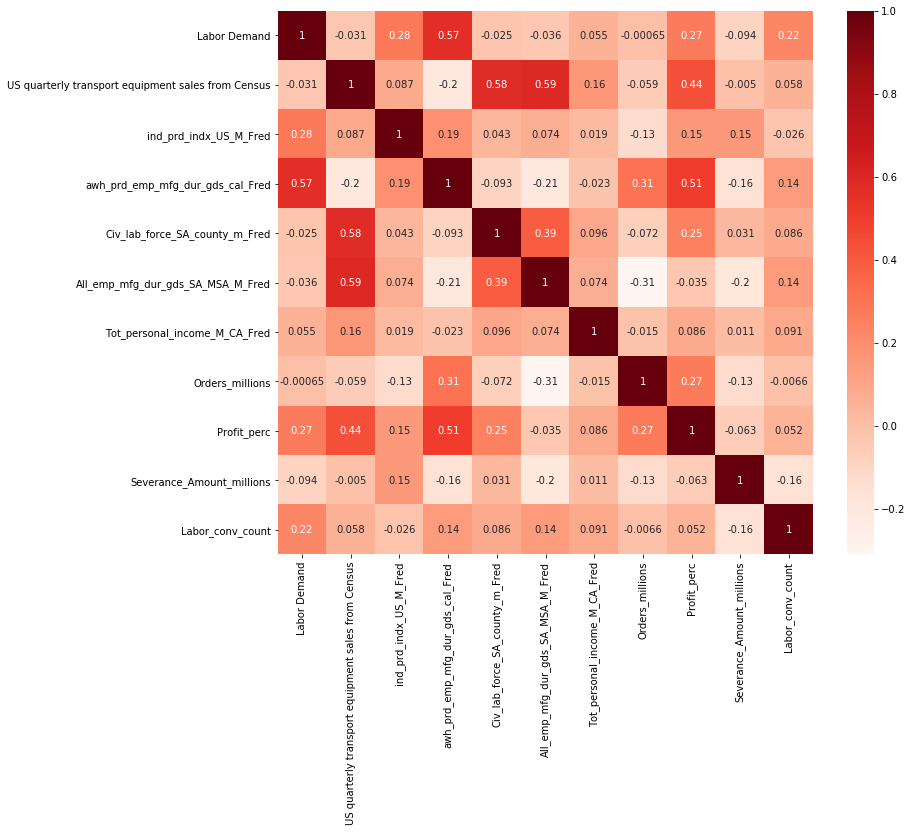

In [62]:
plt.figure(figsize=(12,10))
cor = uncorr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show

In [63]:
df_feat_nocorr = df.loc[:,['Labor Demand','US quarterly transport equipment sales from Census',
       'ind_prd_indx_US_M_Fred', 'awh_prd_emp_mfg_dur_gds_cal_Fred',
       'Civ_lab_force_SA_county_m_Fred', 'All_emp_mfg_dur_gds_SA_MSA_M_Fred',
       'Tot_personal_income_M_CA_Fred', 'Orders_millions', 'Profit_perc',
       'Severance_Amount_millions', 'Labor_conv_count']]

In [49]:
df_feat_nocorr.reset_index(drop=True, inplace=True)

# 1. Variance Threshold technique
- A variance inflation factor(VIF) detects multicollinearity, it is when there’s correlation between predictors (i.e. independent variables) in a model; it’s presence can adversely affect your results. 
- The VIF estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model

In [50]:
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=10):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print('starting number of variables:', len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))
        print('Current maximum VIF: ', max(vif))
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('maximum VIF in the variables: ', max(vif))
    print('remaining number of variables:', len(variables))
    print('Remaining variables:', [variables])
    return X[[i for i in variables]]
Var_feat= ['US quarterly transport equipment sales from Census',
       'ind_prd_indx_US_M_Fred', 'awh_prd_emp_mfg_dur_gds_cal_Fred',
       'Civ_lab_force_SA_county_m_Fred', 'All_emp_mfg_dur_gds_SA_MSA_M_Fred',
       'Tot_personal_income_M_CA_Fred', 'Orders_millions', 'Profit_perc',
       'Severance_Amount_millions', 'Labor_conv_count']
X = df_feat_nocorr[Var_feat] 

X2 = calculate_vif_(X,5) # Actually running the function

starting number of variables: 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Current maximum VIF:  3252.439283855431
Wed Sep  9 16:14:15 2020 dropping 'ind_prd_indx_US_M_Fred' at index: 1
starting number of variables: 9
Current maximum VIF:  1303.1222672565311
Wed Sep  9 16:14:15 2020 dropping 'awh_prd_emp_mfg_dur_gds_cal_Fred' at index: 1
starting number of variables: 8
Current maximum VIF:  82.56130229347538
Wed Sep  9 16:14:15 2020 dropping 'Civ_lab_force_SA_county_m_Fred' at index: 1
starting number of variables: 7
Current maximum VIF:  43.07473300807202
Wed Sep  9 16:14:15 2020 dropping 'All_emp_mfg_dur_gds_SA_MSA_M_Fred' at index: 1
starting number of variables: 6
Current maximum VIF:  33.604028625628594
Wed Sep  9 16:14:15 2020 dropping 'Profit_perc' at index: 3
starting number of variables: 5
Current maximum VIF:  8.481079586605743
Wed Sep  9 16:14:15 2020 dropping 'US quarterly transport equipment sales from Census' at index: 0
starting number of variables: 4
Current maximum VIF:  2.4094275844106066
maximum VIF in the variables:  2.4094275844106066
rem

[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0

- VIF Recommended variables: 'Tot_personal_income_M_CA_Fred', 'Orders_millions', 'Severance_Amount_millions', 'Labor_conv_count'

# Feature Scaling
- helps to normalise the data within a particular range. Sometimes, it also helps in speeding up the calculations

In [32]:
df.reset_index(drop=True, inplace=True)
df.shape
# Scaling exogenous variables
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(df[['US quarterly transport equipment sales from Census',
       'ind_prd_indx_US_M_Fred', 'awh_prd_emp_mfg_dur_gds_cal_Fred',
       'Civ_lab_force_SA_county_m_Fred', 'All_emp_mfg_dur_gds_SA_MSA_M_Fred',
       'Tot_personal_income_M_CA_Fred', 'Orders_millions', 'Profit_perc',
       'Severance_Amount_millions', 'Labor_conv_count']].astype(np.float))
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input
# Scaling Endo variables
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(df[['Labor Demand']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output
y.rename(columns={0:'Labor Demand'}, inplace= True)

X.rename(columns={0:'US quarterly transport equipment sales from Census',
       1:'ind_prd_indx_US_M_Fred', 2:'awh_prd_emp_mfg_dur_gds_cal_Fred',
       3:'Civ_lab_force_SA_county_m_Fred', 4:'All_emp_mfg_dur_gds_SA_MSA_M_Fred',
      5: 'Tot_personal_income_M_CA_Fred', 6:'Orders_millions', 7:'Profit_perc',
       8:'Severance_Amount_millions', 9:'Labor_conv_count'}, inplace=True)

# Selecting train test

In [33]:
# Train and Test selection 
train_exo, test_exo, train_endo, test_endo = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=0)

In [34]:
train_exo.shape

(41, 10)

In [35]:
X.shape

(55, 10)

# Feature selection using Decision tree regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(DecisionTreeRegressor())
sel.fit(train_exo, train_endo)

SelectFromModel(estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [53]:
sel.get_support()
selected_feat= train_exo.columns[(sel.get_support())]
len(selected_feat)
print('Features Selected by DCT- SelectFromModel{}'.format(selected_feat))

Features Selected by DCT- SelectFromModelIndex(['awh_prd_emp_mfg_dur_gds_cal_Fred', 'Orders_millions'], dtype='object')


# Features selection by Random forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(train_exo, train_endo)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(train_exo, train_endo), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(test_exo, test_endo)))


C:\Users\z0047and\Anaconda3\envs\tsa_course\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R^2 Training Score: 0.96 
OOB Score: 0.63 
R^2 Validation Score: 0.65


# Implementing permutation importance technique
- measure the importance of a feature by calculating the increase in the model's prediction error after permuting the feature
- A feature is "important" if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction

In [41]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, train_exo, train_endo):
    return r2_score(train_endo, rf.predict(train_exo))

perm_imp_rfpimp = permutation_importances(rf, train_exo, train_endo, r2)

In [42]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, train_exo, train_endo):
    return r2_score(train_endo, rf.predict(train_exo))

perm_imp_rfpimp = permutation_importances(rf, train_exo, train_endo, r2)


In [43]:
print('Important feature by Permutaion Importance module of Rfpimp')
perm_imp_rfpimp

Important feature by Permutaion Importance module of Rfpimp


,Importance
Feature,
awh_prd_emp_mfg_dur_gds_cal_Fred,1.295675
Orders_millions,0.193328
All_emp_mfg_dur_gds_SA_MSA_M_Fred,0.075723
Severance_Amount_millions,0.071478
Civ_lab_force_SA_county_m_Fred,0.063957
ind_prd_indx_US_M_Fred,0.045999
US quarterly transport equipment sales from Census,0.019216
Profit_perc,0.018329
Tot_personal_income_M_CA_Fred,0.015056


In [44]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

# Feature Slection usiing eli5 

In [45]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(train_exo, train_endo)
perm_imp_eli5 = imp_df(X.columns, perm.feature_importances_)

In [46]:
print('Important feature by Permutaion Importance module of Eli5')
perm_imp_eli5

Important feature by Permutaion Importance module of Eli5


,feature,feature_importance
0,awh_prd_emp_mfg_dur_gds_cal_Fred,0.948231
1,Orders_millions,0.182183
2,Severance_Amount_millions,0.069804
3,All_emp_mfg_dur_gds_SA_MSA_M_Fred,0.062833
4,ind_prd_indx_US_M_Fred,0.050016
5,Civ_lab_force_SA_county_m_Fred,0.048102
6,US quarterly transport equipment sales from Ce...,0.034185
7,Profit_perc,0.018925
8,Tot_personal_income_M_CA_Fred,0.013993
9,Labor_conv_count,0.011124


# Below  Combination of Exogenous Variable are fed to SARIMAX for Labor Demand Prediction
- 'awh_prd_emp_mfg_dur_gds_cal_Fred',
- 'Civ_lab_force_SA_county_m_Fred'
- 'All_emp_mfg_dur_gds_SA_MSA_M_Fred'
- 'Orders_millions'
- 'Profit_perc'
- 'Severance_Amount_millions'
- 'Labor_conv_count'
- 'wage_max'

In [ ]:
plt.figure(figsize=(12,10))
cor = uncorr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show

In [52]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')